# Strategy Testing

Will just be using this notebook for strategy testing for now.

In [2]:
from dotenv import load_dotenv
from binance.client import Client as bnb_client
import os

load_dotenv()
# need TLD in US if US
client = bnb_client(tld='US', api_key=os.getenv('BINANCE_API'), api_secret=os.getenv('BINANCE_SECRET'))

In [3]:
all_binance_symbols =[symbol['symbol'] for symbol in client.get_exchange_info()['symbols']]
print(len(all_binance_symbols))

all_usdt_pairs = [symbol['symbol']  for symbol in client.get_exchange_info()['symbols'] if symbol['quoteAsset'] == 'USDT']
len(all_usdt_pairs)

546


175

In [4]:

import datetime
import pandas as pd 
import numpy as np 

def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.datetime.fromtimestamp(x/1000, datetime.timezone.utc))
    data['close_time'] = data['close_time'].map(lambda x: datetime.datetime.fromtimestamp(x/1000, datetime.timezone.utc))
    return data 

univ = all_binance_symbols

freq = '1h'
filename = 'binance_{freq}_px.pkl'.format(freq=freq)
if filename not in os.listdir():
    px = {}
    for x in univ:
        data = get_binance_px(x,freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
    px.to_pickle(filename)
else:
    px = pd.read_pickle(filename)
ret = px.pct_change()

C:\Users\joshu\AppData\Local\Temp\ipykernel_8380\366739778.py:32: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = px.pct_change()


We now have the history for one hour returns for all Binance coins

In [5]:
# get top correlated pairs
usdt_ret = ret[all_usdt_pairs].rolling(1).mean()
usdt_ret_last3y = ret.loc['2022-01-01':'2023-12-31'][all_usdt_pairs]
corr = usdt_ret_last3y.corr()
corr = corr.unstack().reset_index()
corr = corr[corr[0].abs() < 1]
corr[corr['level_0'] == 'BTCUSDT'].sort_values(axis=0, by = [0])

,level_0,level_1,0
25,BTCUSDT,BUSDUSDT,-0.043845
165,BTCUSDT,FORTUSDT,-0.017955
122,BTCUSDT,BTRSTUSDT,-0.007321
112,BTCUSDT,ILVUSDT,-0.003381
29,BTCUSDT,PAXGUSDT,0.000448
...,...,...,...
14,BTCUSDT,VETUSDT,0.715203
6,BTCUSDT,ADAUSDT,0.718167
45,BTCUSDT,MATICUSDT,0.731124
5,BTCUSDT,BNBUSDT,0.738681


# Testing Hypothesis 1: short term 1h reversal for correlated baskets of 0.5 with BTC

I want to test a correlation basket strategy with bitcoin. I use last three years of data.

What stays the same:
- the basket of coins with corr > .6 with BTC
- one hour data
- in sample is 2022-2023
- reversal

Things to optimize
- portfolio weightings method and speed of signal
    - Ideas
        - rank/rank threshold with sma, ewma
- when to trade
    - Ideas
        - when BTC vol is high/low for last 4 hours
        - when twitter mention of BTC is high
        - only during standard business hours

Tested already
both rank threshold and rank have sharpe of 29 without transaction costs
correlation and rank if lower sharpe than just rank
high sma and ewma makes sharpe ~ -4
- sma with rank/rank threshold weightings at all times: very negative
- ewma with rank/rank threshold weightings at all times : very negative 
- ewma low signal speed w rank threshold at times 9-20:00 utc : very negative (-20 - -60)
    - sharpe is better than all times, focusing further to 12-15 is even better
- ewma low/high singal speed with rank threshold at low activity times during the day
    - high activity times perform just as well as low activity times


In [306]:
basket = pd.concat([corr[(corr['level_0'] == 'BTCUSDT') & (corr[0] > 0.5)]['level_1'],pd.Series(['BTCUSDT'])])
basket_ret = usdt_ret_last3y[basket]

In [307]:
if 'bitcoin_data.pkl' not in os.listdir():
    bitcoin_data = get_binance_px('BTCUSDT',freq)
    bitcoin_data.to_pickle('bitcoin_data.pkl')
bitcoin_data = pd.read_pickle('bitcoin_data.pkl')

In [308]:
bitcoin_data['volume'] = bitcoin_data['volume'].astype(float)

in_sample_bitcoin_data = bitcoin_data.set_index('open_time').loc['2022-01-01':'2023-12-31']
low_activity = in_sample_bitcoin_data['volume'] < in_sample_bitcoin_data['volume'].rolling(6).mean()

In [ ]:
def rank_threshold_weighting(x):
    y = x.rank(pct = True).subtract(0.5).map(lambda val: 0 if -0.4 <= val <= 0.4 else val)
    return -y/y.abs().sum()

def rank_weighting(x):
    x = x.rank(pct = True).subtract(0.5)
    return -x/x.abs().sum()

def filter_trading_hours(df, lookback = 6):
    high_activity = in_sample_bitcoin_data[in_sample_bitcoin_data['volume'] > in_sample_bitcoin_data['volume'].rolling(lookback).median()].index
    # set weights to 0 if not low activity
    df.loc[high_activity] = 0
    return df

def correlation_weighting(df, window = 48):
    cor = basket_ret.rolling(window).corr()['BTCUSDT'].unstack()
    df = df*(cor.fillna(0))
    return df.apply(lambda x: x/x.abs().sum(), axis = 1)

def sma(df):
    return df.rolling(96).mean()

def ewma(df, alpha = 0.2):
    return df.ewm(alpha = alpha).mean()

port_weights =(filter_trading_hours(basket_ret.apply(rank_weighting,axis=1)))

In [354]:
port_weights

,ETHUSDT,BCHUSDT,LTCUSDT,BNBUSDT,ADAUSDT,BATUSDT,ETCUSDT,XLMUSDT,DOGEUSDT,ATOMUSDT,...,FTMUSDT,MATICUSDT,MANAUSDT,ALGOUSDT,LINKUSDT,NEARUSDT,GALAUSDT,APEUSDT,OPUSDT,BTCUSDT
2022-01-01 00:00:00+00:00,0.020833,0.041667,-0.034722,0.027778,-0.013889,-0.076389,-0.000000,0.069444,0.055556,-0.055556,...,-0.062500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048611
2022-01-01 01:00:00+00:00,-0.034722,-0.000000,0.055556,-0.013889,0.013889,-0.027778,0.020833,0.006944,-0.006944,-0.076389,...,0.069444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.048611
2022-01-01 02:00:00+00:00,-0.041667,0.020833,-0.000000,-0.020833,0.048611,0.069444,-0.076389,-0.006944,0.034722,-0.069444,...,-0.013889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006944
2022-01-01 03:00:00+00:00,0.006944,-0.041667,0.020833,-0.027778,-0.013889,0.048611,0.062500,-0.069444,-0.006944,0.076389,...,-0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.034722
2022-01-01 04:00:00+00:00,-0.041667,-0.027778,0.006944,-0.000000,0.069444,0.041667,-0.013889,-0.020833,0.013889,-0.083333,...,0.076389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.048611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00+00:00,0.036000,-0.040000,-0.012000,-0.016000,0.024000,-0.000000,-0.000000,-0.000000,0.032000,-0.056000,...,-0.052000,0.028000,-0.000000,-0.036000,-0.024000,-0.064000,-0.020000,0.060000,-0.044000,0.012000
2023-12-31 20:00:00+00:00,-0.015625,0.015625,-0.019531,0.007812,-0.035156,-0.039062,-0.062500,-0.007812,0.003906,0.011719,...,-0.027344,0.054688,-0.000000,-0.003906,0.027344,0.058594,0.023438,-0.054688,0.031250,-0.023438
2023-12-31 21:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-12-31 22:00:00+00:00,-0.062500,-0.046875,-0.015625,-0.054688,-0.035156,0.050781,-0.000000,-0.039062,-0.050781,0.007812,...,0.023438,-0.007812,-0.011719,0.046875,-0.031250,0.035156,0.019531,0.003906,0.031250,-0.058594


In [355]:
bps = 0.0020
asset_to = port_weights.fillna(0).diff().abs()
total_to = asset_to.sum(axis=1)
asset_tcost = asset_to.multiply(bps)
total_tcost = total_to.multiply(bps)
print("Total turnover: " + str(total_to.mean()))
port_ret = (port_weights.shift(1)*basket_ret)-asset_tcost
port_sharpe = port_ret.mean()/port_ret.std()*np.sqrt(24*365)
total_sharpe = port_ret.mean(1).mean()/port_ret.mean(1).std()*np.sqrt(24*365)
print("Total Sharpe: " + str(total_sharpe))

Total turnover: 0.793936404428171
Total Sharpe: -59.88380950996029


<Axes: >

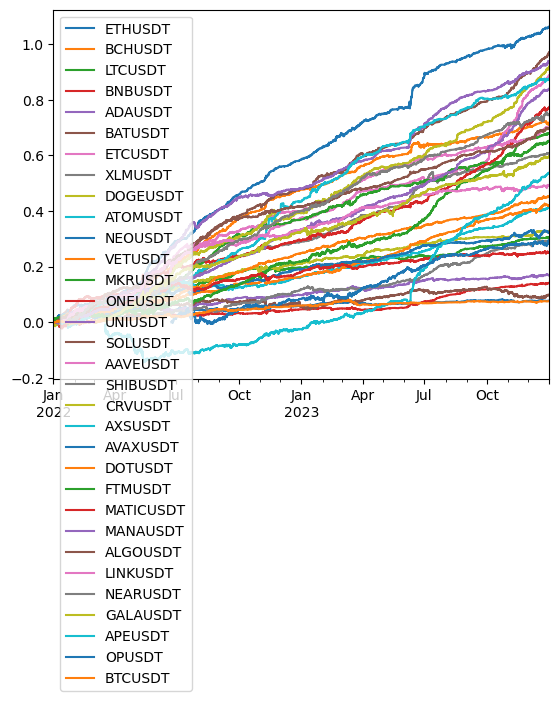

In [340]:
port_ret.cumsum().plot()

The above didn't really work, and using just price volume data - I couldn't find a short term reversal strategy that works well enough to counteract transatction costs.

# Testing hypothesis 1.5: Mean reversion on dynamic BTC correlated basket index

Idea: We will create an index using coins most closely correrlated with BTC, and test a mean reversion.


In [123]:
corr = usdt_ret_last3y.corr()
corr = corr.unstack().reset_index()
corr = corr[corr[0].abs() < 1]
coins = pd.concat([corr[(corr['level_0'] == 'BTCUSDT') & (corr[0] > 0.5)]['level_1'],pd.Series(['BTCUSDT'])])
coins_ret = usdt_ret_last3y[basket]

<Axes: >

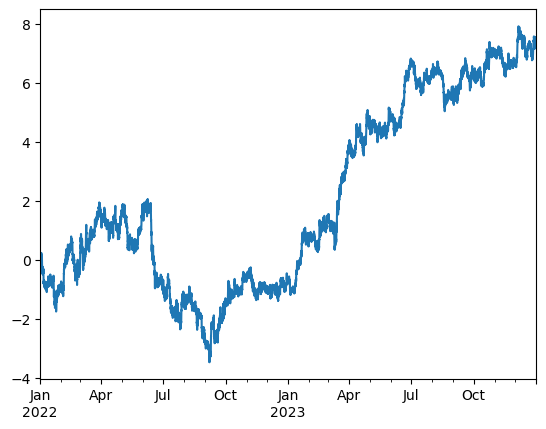

In [282]:
sigma = coins_ret.cov()
sigma_inv = np.linalg.inv(sigma)
basket_vol_sharpe_weighting = coins_ret.fillna(0)@sigma_inv
basket_vol_sharpe_weighting.columns = coins_ret.columns
basket_vol_sharpe_weighting = basket_vol_sharpe_weighting.apply(lambda x: x/x.abs().sum(), axis = 1)
basket_vol_sharpe_weighting_ret = basket_vol_sharpe_weighting.sum(axis = 1)
basket_vol_sharpe_weighting_ret.cumsum().plot()

In [283]:
basket_vol_sharpe_weighting_ret.mean()/basket_vol_sharpe_weighting_ret.std()*np.sqrt(24*365)

0.8347452326003522

<Axes: >

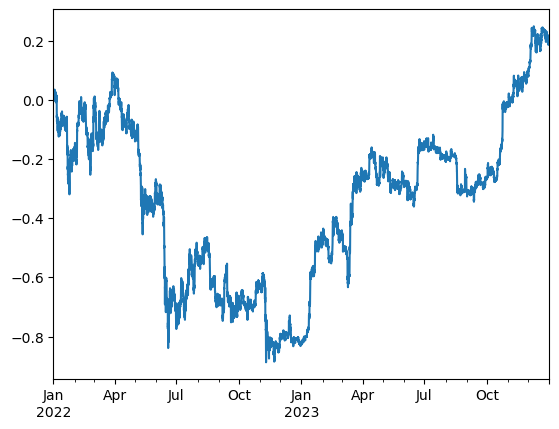

In [104]:
usdt_ret_last3y['BTCUSDT'].cumsum().plot()

In [103]:
usdt_ret_last3y['BTCUSDT'].mean()/usdt_ret_last3y['BTCUSDT'].std()*np.sqrt(24*365)

0.18647108800233334

Signal:

zscore of intercept of coin on basket returns

tested:
holding for one hour
no basket hedge - sharpe of -25 with to = 0.71
with hedging of basket - sharpe of -12 with to = 0.139

dynamic holding
sharpe of -20 with to of 0.0029.
with hedgnig it becomes -12 with to = -0.35


<Axes: >

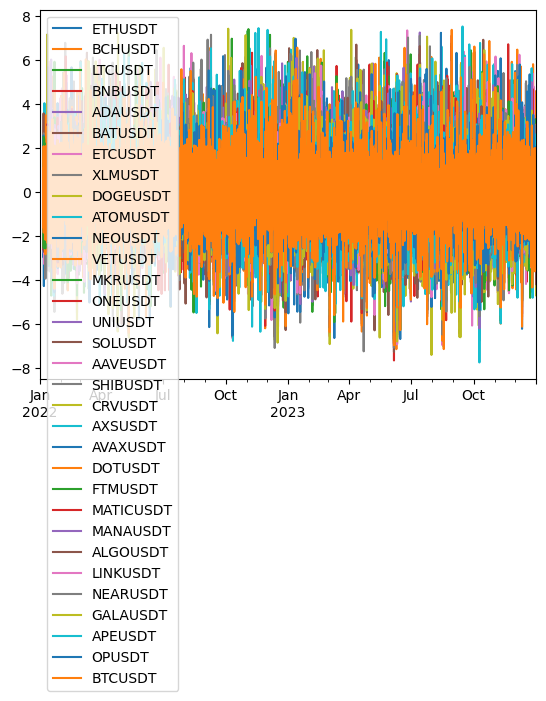

In [271]:
betas = basket_vol_sharpe_weighting_ret.rolling(60).cov(coins_ret).divide(basket_vol_sharpe_weighting_ret.rolling(60).var(), axis = 0)
alphas = coins_ret.rolling(60).mean().subtract(betas.multiply(basket_vol_sharpe_weighting_ret.rolling(60).mean(), axis = 0))
residuals = coins_ret.subtract(alphas.add(betas.multiply(basket_vol_sharpe_weighting_ret, axis = 0)))
std_err = residuals.rolling(60).std()
z_scores = residuals.div(std_err)
z_scores.plot()

In [321]:
def z_score_thresholding(x, threshold = 4):
    x = x.map(lambda x: 0 if abs(x) < threshold else x)
    return x.divide(x.abs().sum(1),axis = 0)

def filter_trading_hours(df, lookback = 6):
    high_activity = in_sample_bitcoin_data[in_sample_bitcoin_data['volume'] > in_sample_bitcoin_data['volume'].rolling(lookback).median()].index
    # set weights to 0 if not low activity
    df.loc[high_activity] = 0
    return df

def dynamic_holding(y, enter_z = 4, exit_z = 1):
    # x are zscores
    # if previous entry was 0, then enter if zscore > enter_z
    # if previous entry was positive, then exit if zscore < exit_z
    # if previous entry was negative, then enter if zscore > -exit_z
    for col in y.columns:
        x = y[col]
        for i in range(1,len(x)):
            if x.iloc[i-1] > 0:
                if x.iloc[i] < exit_z:
                    x.iloc[i] = 0
            elif x.iloc[i-1] < 0:
                if x.iloc[i] > -exit_z:
                    x.iloc[i] = 0
            elif x.iloc[i] == 0:
                if -enter_z < x.iloc[i] < enter_z:
                    x.iloc[i] = 0
        y[col] = x
    return y/y.abs().sum(axis = 1)

def hedge_with_basket(x,betas= betas):
    return x.fillna(0) - basket_vol_sharpe_weighting.multiply((x*(betas)).sum(1), axis = 0)
port_weights = (z_score_thresholding(z_scores))


In [324]:
bps = 0.0020
asset_to = port_weights.fillna(0).diff().abs()
total_to = asset_to.sum(axis=1)
asset_tcost = asset_to.multiply(bps)
total_tcost = total_to.multiply(bps)
print("Total turnover: " + str(total_to.mean()))
port_ret = (port_weights.shift(1)*basket_ret)
port_sharpe = port_ret.mean()/port_ret.std()*np.sqrt(24*365)
total_sharpe = port_ret.mean(1).mean()/port_ret.mean(1).std()*np.sqrt(24*365)
print("Total Sharpe: " + str(total_sharpe))

Total turnover: 0.13537536359972982
Total Sharpe: -11.901446348172698


<Axes: >

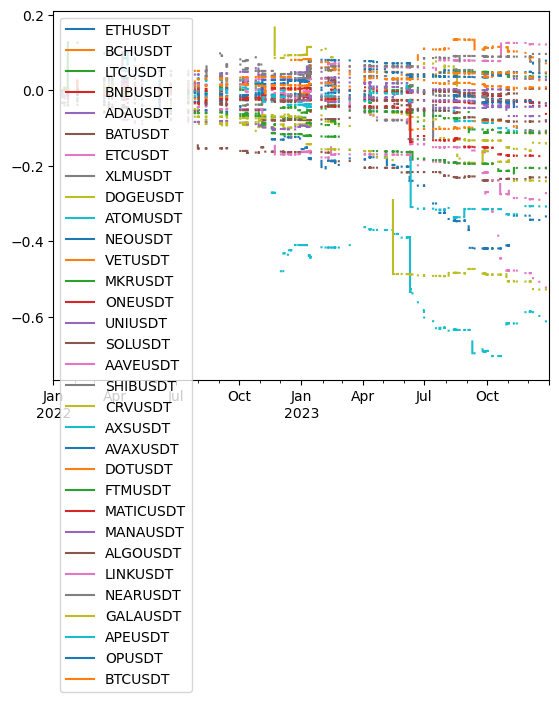

In [325]:
port_ret.cumsum().plot()